<a href="https://colab.research.google.com/github/rheazh/Data-Analysis/blob/main/Rhea's_Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [2]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [3]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [4]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

generally there seems to be a correlation between FT% and FG% however there are some outliers that would maybe suggest that player position could be playing a role in this.

<Axes: xlabel='FT%', ylabel='FG%'>

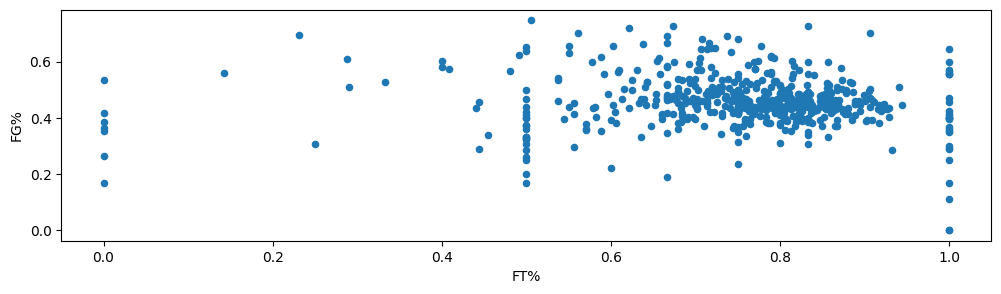

In [5]:
basketball.plot(x="FT%", y="FG%", figsize=(12, 3), kind="scatter")

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

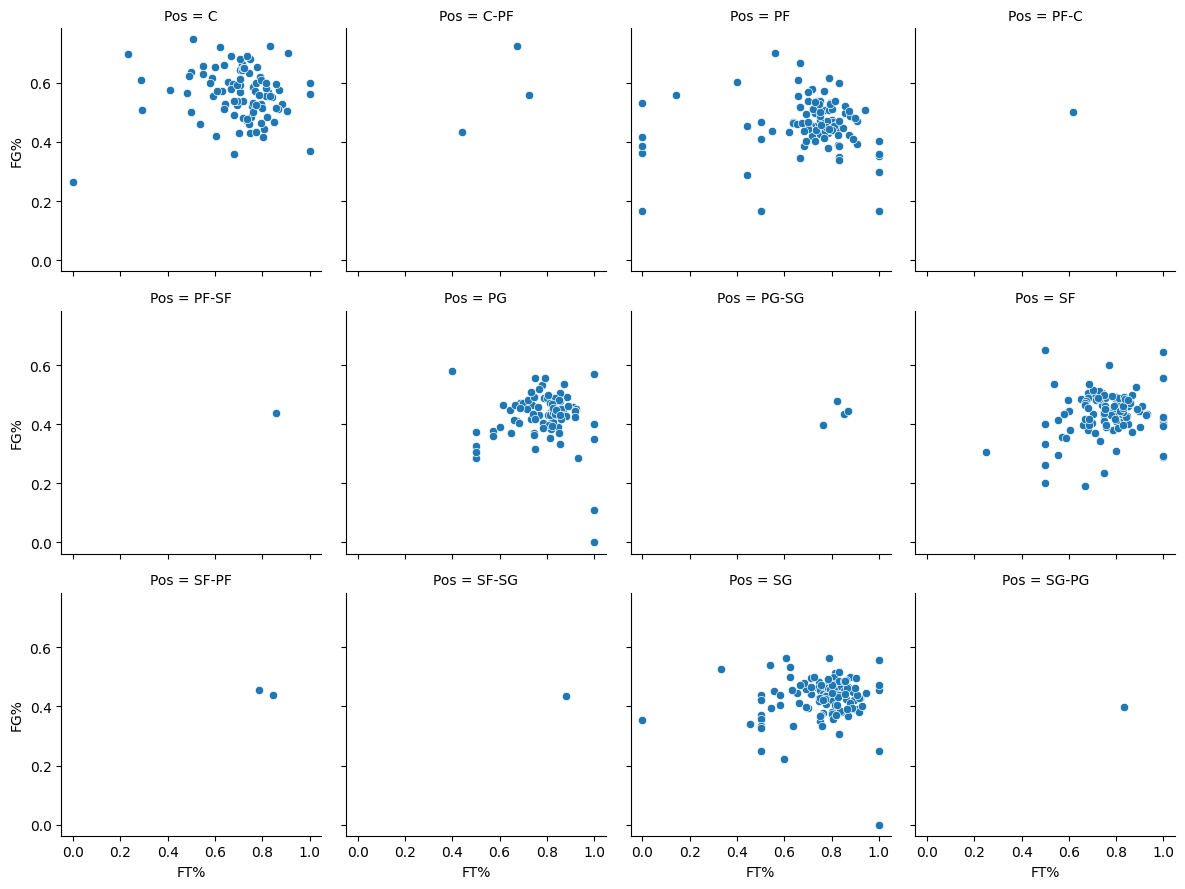

In [6]:
basketball = pd.read_csv(url_basketball, dtype={'Pos': 'category'})
g = sns.FacetGrid(basketball, col="Pos", col_wrap=4)
g.map(sns.scatterplot, 'FT%', 'FG%')


**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

**A linear regression model won't work well on the full dataset because the relationship between FT% and FG% is different for each position. Generally different positions have different shooting patterns and a single line can't capture this. Also, player position is a categorical variable that a simple linear model can't handle properly. There are also issues like outliers and changing spread in the data that violate the assumptions of linear regression, making the model less accurate. Instead, it would be better to separate the data by position or use a more advanced model.**

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [7]:
#downloads the data from github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [8]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

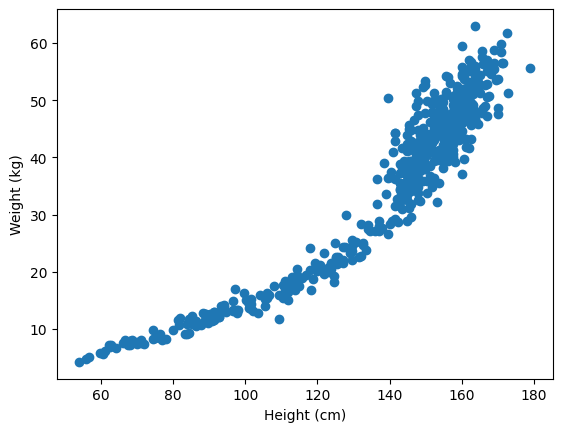

In [9]:
#heigh v weight scaterplot
plt.scatter(howell['height'], howell['weight'])
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.show()

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

Output()

Output()

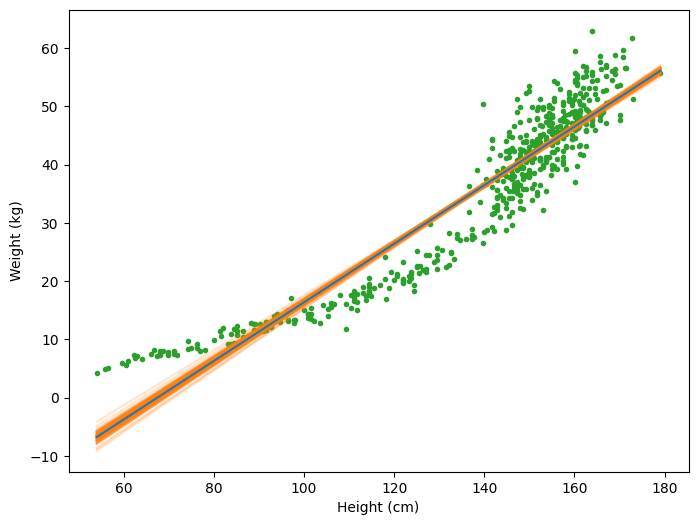

In [10]:
with pm.Model() as model_howell:
    # Priors for the intercept and slope
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    # Linear model for mean weight
    μ = pm.Deterministic("μ", α + β * howell.height)

    # Prior for the standard deviation of the likelihood
    σ = pm.HalfCauchy("σ", 10)

    # Likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    # Sample from the posterior
    idata_howell = pm.sample()

# Extract the posterior samples
posterior = az.extract(idata_howell, num_samples=100)

# Generate a range of x-values (heights) for plotting
x_plot = xr.DataArray(
    np.linspace(howell.height.min(), howell.height.max(), 50),
    dims="plot_id"
)

# Mean line for the predicted weight based on the posterior samples
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

# Generate lines for the regression using the posterior samples
lines = posterior["α"] + posterior["β"] * x_plot

# Plot results
_, ax = plt.subplots(figsize=(8, 6))

# Plot lines of regression from the posterior samples
ax.plot(x_plot, lines.T, c="C1", alpha=0.2)

# Plot mean regression line
ax.plot(x_plot, mean_line, c="C0")

# Plot raw data
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax.set_xlabel("Height (cm)")
ax.set_ylabel("Weight (kg)")
plt.show()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

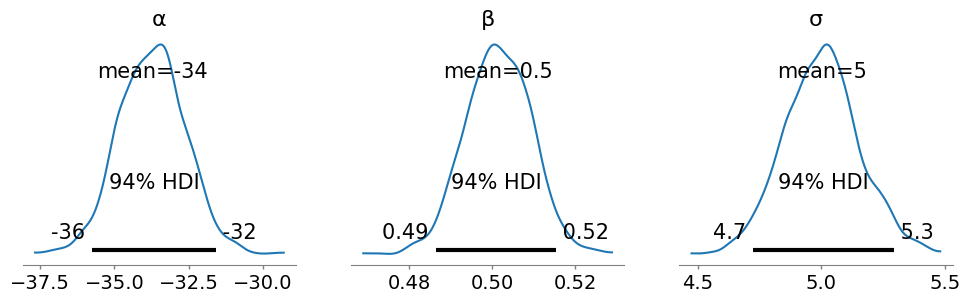

In [11]:
az.plot_posterior(idata_howell, var_names=["~μ"], figsize=(12, 3))

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

In [12]:
# Generate posterior predictive samples for the howell model
posterior_predictive = pm.sample_posterior_predictive(idata_howell, model=model_howell, extend_inferencedata=True)

Output()

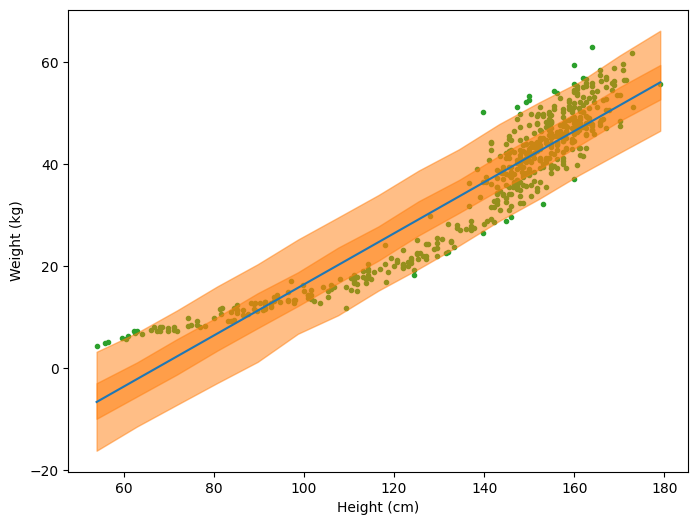

In [13]:
mean_line = idata_howell.posterior["μ"].mean(("chain", "draw"))

heights = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(heights)
x = np.linspace(heights.min(), heights.max(), 15)

y_pred_q = idata_howell.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)

y_hat_bounds = iter(
    [
        PchipInterpolator(heights[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

# Plotting the results
_, ax = plt.subplots(figsize=(8, 6))

# Plot the raw data (height vs weight)
ax.plot(howell.height, howell.weight, "C2.", zorder=-3, label="Observed Data")

# Plot the mean regression line (expected line)
ax.plot(howell.height[idx], mean_line[idx], c="C0", label="Mean regression line")

# Graph the 94% and 50% HDI (Posterior Predictive intervals)
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5, label="94% HDI")

# Add labels and title
ax.set_xlabel("Height (cm)")
ax.set_ylabel("Weight (kg)")
plt.show()



<Axes: xlabel='y_pred'>

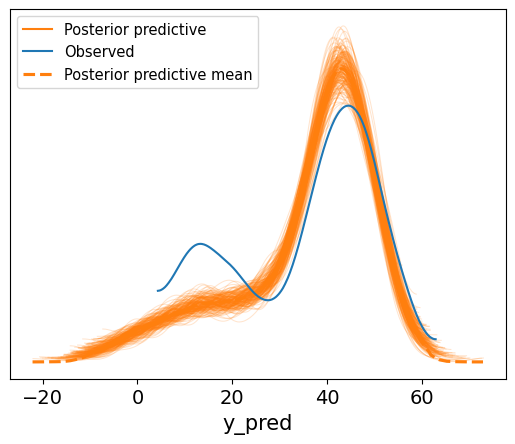

In [14]:
az.plot_ppc(idata_howell, num_pp_samples=200, colors=["C1", "C0", "C1"])


I think that the fit on task 5 is just alright but I could probably find something much better by trying another one. Since most of the data points lie within the shaded posterior predicitive, it seems like its capturing the variability relativley well but i wouldnt say that the points cluster very tightly near the mean line, leaving me to think that there should be some room for improvement.

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [19]:
with pm.Model() as model_nb:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)

    #the linear part of our model,
    #but with a twist:
    #our line is exponentiated, in order to make our all our values positive
    μ = pm.Deterministic("μ", pm.math.exp(α + β * howell.height))

    #prior for the likelihood's standard deviation
    σ = pm.HalfNormal("σ", 10)

    #likelihood
    y_pred = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=howell.weight)

    idata_nb = pm.sample()


Output()

Output()

In [20]:
pm.sample_posterior_predictive(idata_nb, model = model_nb, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

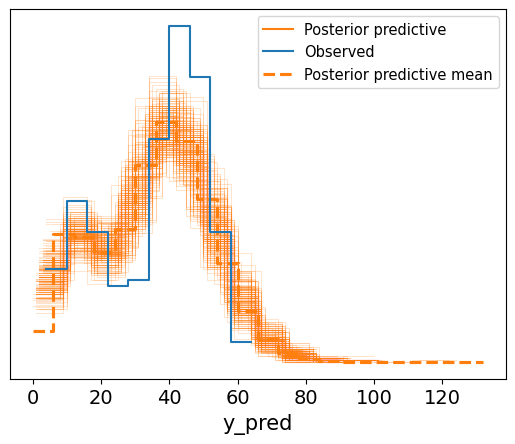

In [21]:
az.plot_ppc(idata_nb, num_pp_samples=200, colors=["C1", "C0", "C1"])

This fit so far is looking a little bit better than the normal distribution. The observed line is intersecting the posterior predicitive much more but this time it surpasses the peak.

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

Text(0, 0.5, 'weight')

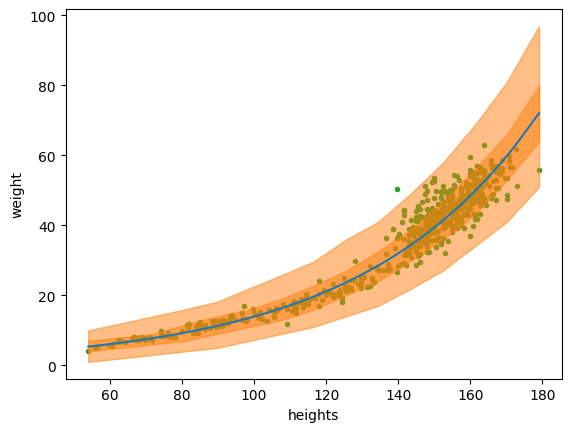

In [25]:
mean_line = idata_nb.posterior["μ"].mean(("chain", "draw"))
temperatures = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(heights)
x = np.linspace(heights.min(), heights.max(), 15)
y_pred_q = idata_nb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(heights[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax.plot(howell.height[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("heights")
ax.set_ylabel("weight")

This fit is very good. almost all of the data points in this set lie within the shaded predicted region. I think that by removing the negative counts, it was able to run much more smoothly and narrow the estimates down.